In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
# We change the default level of the logger so that
# we can see what's happening with caching.
import logging, sys, os
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

import py21cmfast as p21c

# For plotting the cubes, we use the plotting submodule:
from py21cmfast import plotting

# For interacting with the cache
from py21cmfast import cache_tools

import numpy as np
import collections.abc
#py21cmmc needs the four following aliases to be done manually.
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping
#py21cmmc needs the below
np.int = np.int32
#Now import py21cmmc
from py21cmmc import analyse
from py21cmmc import mcmc
import py21cmmc as p21mc


In [38]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.fftpack import fftn, fftshift


# Compute the power spectrum using 3D Fourier transform

def power_spectrum_fft_1(signal):
    # Compute the power spectrum using the Fourier transform
    fft_signal = np.fft.fftn(signal)
    fft_amplitudes = np.abs(fft_signal) ** 2
    dim = len(signal)
    kfreq = np.fft.fftfreq(dim*np.pi/100, d=2*np.pi/100)
    kfreq3D = np.meshgrid(kfreq, kfreq, kfreq)
    kfreq_norm = np.sqrt(kfreq3D[0]**2 + kfreq3D[1]**2 + kfreq3D[2]**2)
    kfreq_norm = kfreq_norm.flatten()
    fft_amplitudes = fft_amplitudes.flatten()
    kfreq_bins = np.arange(0.5, dim//2+1, 1.0)
    kvals = 0.5 * (kfreq_bins[1:] + kfreq_bins[:-1])
    amplitude_bins, _, _ = stats.binned_statistic(kfreq_norm, fft_amplitudes, statistic='mean', bins=kfreq_bins)
    amplitude_bins *= (4/3) * np.pi * (kfreq_bins[1:]**3 - kfreq_bins[:-1]**3)
    # Convert to the dimensionless power spectrum
    amplitude_bins *= (kvals**3)/2*(np.pi**2)
    return amplitude_bins, kvals

def power_spectrum_fft_2(signal):
    minx = 0
    maxx = 100
    npoints = len(signal)
    dx = (maxx - minx)/(npoints)
    #x = np.arange(minx, maxx, dx)

    nft = np.fft.fftn(signal, norm='ortho')
    freq = np.fft.fftfreq(40, d=1.0)*40*np.pi/100
    #print(freq)
    freq3D = np.meshgrid(freq, freq, freq)
    coeff = (100/(2*np.pi))**2
    freq_norm = np.sqrt(coeff*(freq3D[0]**2 + freq3D[1]**2 + freq3D[2]**2))
    freq_norm = freq_norm.flatten()
    #freq = np.array(list(map(lambda x: x+maxx if x<0 else x, freq)))
    #factor = np.exp(-1j*freq_norm*minx)
    factor = 1 # minx = 0
    npoints = len(freq_norm)
    aft = np.abs(nft)**2
    #aft = dx**3 * np.power(npoints/100, 1.5) * nft * factor
    #aft = aft**2
    aft = aft.flatten()
    #aft = (aft)*(freq_norm**3)/2*(np.pi**2)
    aft_bin, freq_bin, _ = stats.binned_statistic(freq_norm, aft, statistic='sum', bins=20)
    freq_bin = (freq_bin[1:] + freq_bin[:-1])/2
    #print(freq_bin)
    return aft_bin, freq_bin
    
def power_spectrum_cmmc(signal):
    # Compute the power spectrum using the p21cmmc package
    ps = p21mc.Likelihood1DPowerCoeval.compute_power(signal, L=100, n_psbins = None, 
    log_bins = False) 
    return ps   



In [39]:
def write_data(data, filename):
    with open(filename, 'w') as f:
        f.write('{0} {1} {2}\n'.format(data.shape[0],  data.shape[1], data.shape[2]))
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                for k in range(data.shape[2]):
                    f.write('{0} '.format(data[i,j,k]))
                f.write('\n')

def read_data(filename):
    return np.loadtxt(filename)

def write_ps(ps, kvals, filename):
    with open(filename, 'w') as f:
        for i in range(len(ps)//2):
            f.write('{0} {1}\n'.format(ps[i], kvals[i]))


In [40]:
from compute_power_spectrum import ComputePowerSpectrum as CPS
def plot_power_spectrum(initial_conditions, astro_params, flag_options):
    fig, ax = plt.subplots(4, 3, figsize=(14,16), sharex = True, sharey = True, tight_layout = True)
    ps1_list = []
    ps2_list = []
    ps3_list = []
    redshift_list = [14, 10, 6]
    for i, redshift in enumerate(redshift_list):
        show_cbar = (redshift == 6)
        #######
        # Create perturbed field at the redshift
        perturbed_field = p21c.perturb_field( redshift = redshift, init_boxes = initial_conditions)
        plotting.coeval_sliceplot(perturbed_field, "density", ax=ax[0][i], fig = fig, vmin = -0.5, vmax = 0.9, cbar_label=r'Density Contrast ($\delta_nl\equiv\rho/\overline{\rho}$ -1)')
        ax[0][i].title.set_text('redshit={0}-Density'.format(redshift))

        #######
        # Compute the spin temperatures
        spin_temp = p21c.spin_temperature(
            perturbed_field = perturbed_field,
            zprime_step_factor=1.05,
            astro_params = astro_params,
            flag_options = flag_options
        )
        plotting.coeval_sliceplot(spin_temp, "Ts_box", ax=ax[1][i], fig = fig, vmin = 0, vmax = 1200, cbar_label='Spin Temperature (K)');
        ax[1][i].title.set_text('redshit={0}-Spin Temperature'.format(redshift))
        # Try accessing global_Ts
        #global_Ts = spin_temp.Ts_box_struct.global_Ts
        #print('Global TS at redshit={0} is {1:.4f}'.format(redshift, global_Ts))

        #######
        # Compute ionization
        ionized_field = p21c.ionize_box(
            spin_temp = spin_temp,
            zprime_step_factor=1.05,
            flag_options = flag_options
        )
        plotting.coeval_sliceplot(ionized_field, "xH_box", ax=ax[2][i], fig = fig, vmin = 0, vmax = 1);
        ax[2][i].title.set_text('redshit={0}-Neutral H fraction'.format(redshift))

        #######
        # Compute brightness temperature
        brightness_temp = p21c.brightness_temperature(
            ionized_box = ionized_field,
            perturbed_field = perturbed_field,
            spin_temp = spin_temp
        )
        plotting.coeval_sliceplot(brightness_temp, ax=ax[3][i], fig = fig)
        ax[3][i].title.set_text('redshit={0}-Brightness Temperature'.format(redshift))

        #######
        # Compute Power Spectrum of brightness_temp
        #xscale = user_params["BOX_LEN"]
        #yscale = 1/(xscale**3)
        #write_data(brightness_temp.brightness_temp, 'output/brightness_temp_'+str(redshift)+'.dat')
        #ps1 = power_spectrum_cmmc(brightness_temp.brightness_temp)
        
        #ps1_list.append([ps1[0], ps1[1]])
        ps2 = CPS.compute_power_spectrum(initial_conditions.user_params.HII_DIM, brightness_temp.brightness_temp, initial_conditions.user_params.BOX_LEN)
        write_ps(ps2[0], ps2[1], 'output/ps_'+str(redshift)+'.dat')
        ps2_list.append([ps2[0], ps2[1]])
        #ps3 = power_spectrum_fft_1(brightness_temp.brightness_temp)
        #ps3_list.append([ps3[0]*yscale, ps3[1]/xscale])
        #ps3 = myps(40, brightness_temp.brightness_temp, 100)
    
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.show()
        
    plt.figure(figsize=(14,6))
    for i, ps in enumerate(ps1_list):
        plt.plot(ps[1], ps[0], label = 'p21cmmc: z={0}'.format(redshift_list[i]))
    for i, ps in enumerate(ps2_list):
        plt.plot(ps[1], ps[0], label = 'fft: z={0}'.format(redshift_list[i]))
    plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(0, 100)
    plt.title('Power Spectrum')
    plt.xlabel('h/Mpc')
    plt.ylabel(r'[$\Delta^2$(k)=$\frac{k^3 P(k)}{2\pi^2}$] (mK$^2$)')
    plt.legend()
    plt.show()
    


ps: N=64000
ps: nbox=40
ps: box_size=100
ps: kf=0.06283185307179587, kn=1.2566370614359172
ps: w=[ 0.          0.06283185  0.12566371  0.18849556  0.25132741  0.31415927
  0.37699112  0.43982297  0.50265482  0.56548668  0.62831853  0.69115038
  0.75398224  0.81681409  0.87964594  0.9424778   1.00530965  1.0681415
  1.13097336  1.19380521  1.25663706 -1.19380521 -1.13097336 -1.0681415
 -1.00530965 -0.9424778  -0.87964594 -0.81681409 -0.75398224 -0.69115038
 -0.62831853 -0.56548668 -0.50265482 -0.43982297 -0.37699112 -0.31415927
 -0.25132741 -0.18849556 -0.12566371 -0.06283185]
ps: iweights max_ind=35
ps: N=64000
ps: nbox=40
ps: box_size=100
ps: kf=0.06283185307179587, kn=1.2566370614359172
ps: w=[ 0.          0.06283185  0.12566371  0.18849556  0.25132741  0.31415927
  0.37699112  0.43982297  0.50265482  0.56548668  0.62831853  0.69115038
  0.75398224  0.81681409  0.87964594  0.9424778   1.00530965  1.0681415
  1.13097336  1.19380521  1.25663706 -1.19380521 -1.13097336 -1.0681415
 -1.00

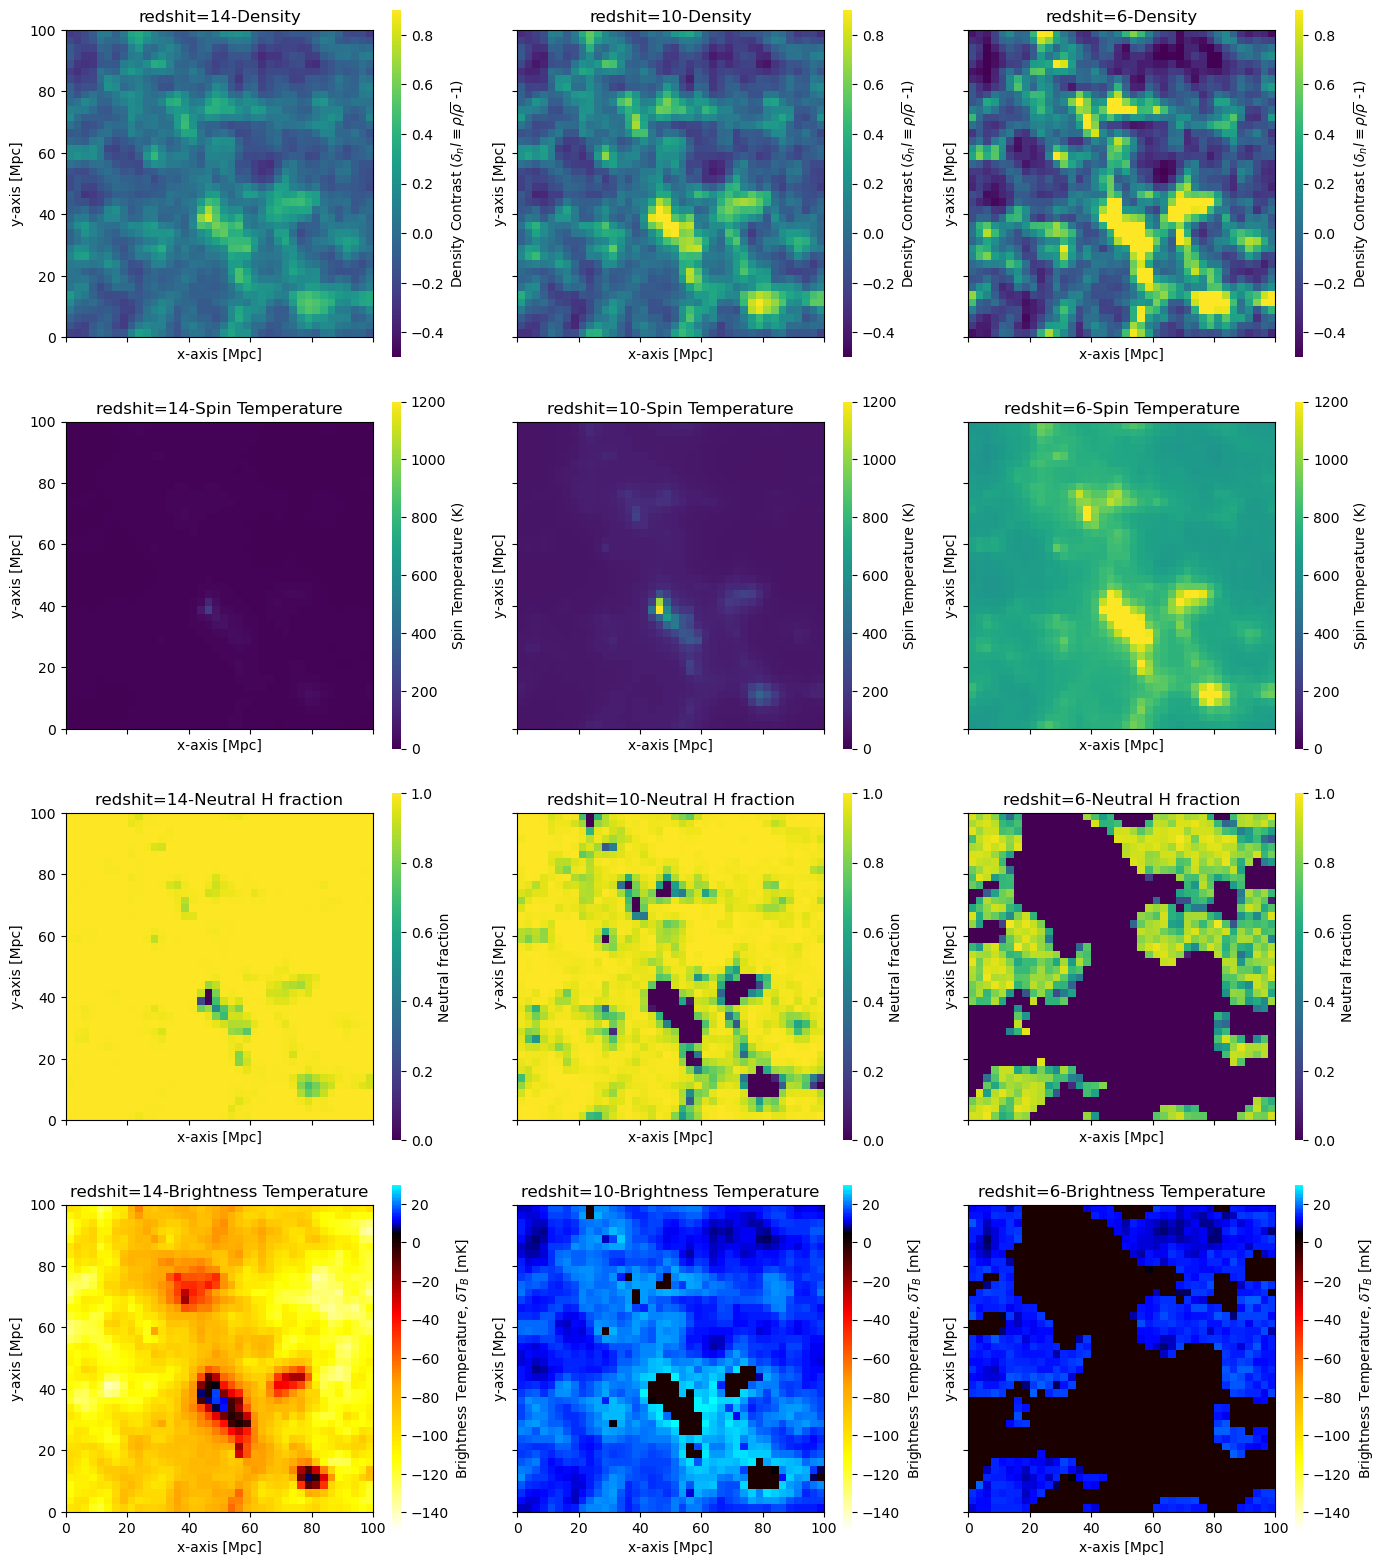

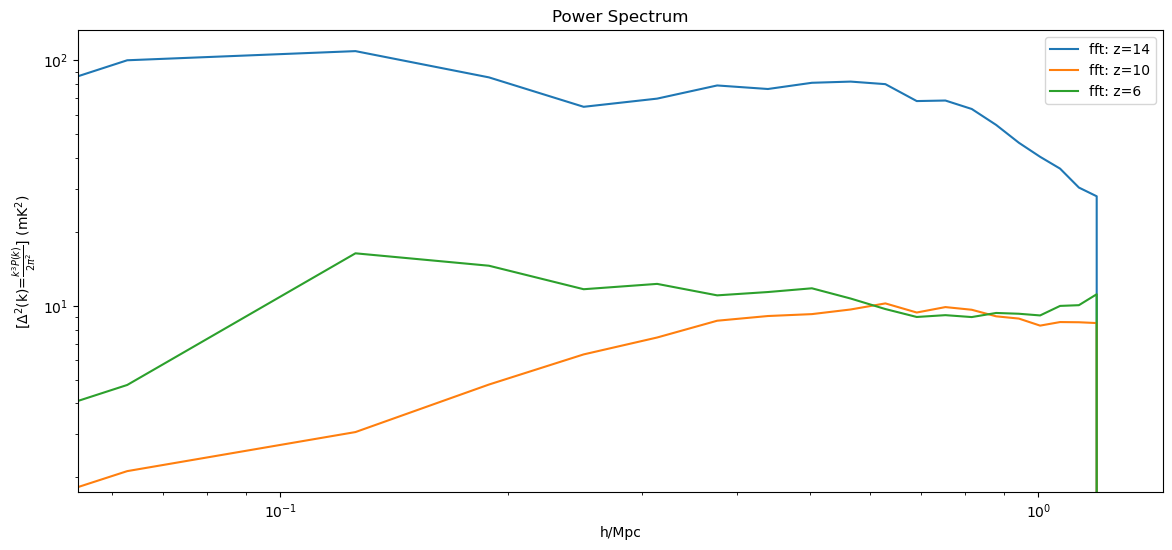

In [41]:

user_params = {"HII_DIM": 40, "BOX_LEN": 100}
astro_params = {"HII_EFF_FACTOR": 15} #"F_STAR10": 0.5} 
flag_options = {} #"USE_MASS_DEPENDENT_ZETA": True, "USE_TS_FLUCT": True}


initial_conditions = p21c.initial_conditions(
    user_params = user_params
    )
plot_power_spectrum(initial_conditions, astro_params, flag_options)

In [42]:
import numpy as np

def read_data(filename):
    with open(filename, "r") as fp:
        nx, ny, nz = map(int, fp.readline().split())
        print(f"nx: {nx}, ny: {ny}, nz: {nz}")
        grid = np.zeros(nx * ny * nz, dtype=float)

        for i in range(nx):
            for j in range(ny):
                nums = next(fp).split()
                for k in range(nz):
                    #print(f"{i} {j} {k} {len(nums)}")
                    grid[k + ny * (j + nx * i)] = float(nums[k])
                    if i < 3 and j < 3 and k < 3:
                        print(f"Reading: {grid[k + ny * (j + nx * i)]} ", end="")
        print()  # for newline after the last print
    return grid

dummy = read_data('data/brightness_temp_6.dat')
dummy = np.reshape(dummy, (40,40,40))
#print(f"dummy: {dummy}")   
myps(40, dummy, 100)

nx: 40, ny: 40, nz: 40
Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 Reading: 0.0 


NameError: name 'myps' is not defined